## Leukaemia Classification using DL

### Approach 3: VGG16

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import os
import skimage.io
import glob
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

#### Data Preparation

In [2]:
# all - positive     hem - negative
train_dataset_0_all = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
# train_dataset_1_all = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
# train_dataset_1_hem = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
# train_dataset_2_all = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
# train_dataset_2_hem = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

valid_data = pd.read_csv('/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [3]:
positives = []
negatives = []

positives.extend(train_dataset_0_all)
# positives.extend(train_dataset_1_all)
# positives.extend(train_dataset_2_all)

negatives.extend(train_dataset_0_hem)
# negatives.extend(train_dataset_1_hem)
# negatives.extend(train_dataset_2_hem)

positives = np.array(positives)
negatives = np.array(negatives)

len(positives),len(negatives)

(2397, 1130)

In [4]:
images = []
labels = []

for i in tqdm(range(0, len(positives))):
    img = imread(positives[i])
    img = resize(img, (180,180))
    images.append(img)
    labels.append(1)
    
for i in tqdm(range(0, len(negatives))):
    img = imread(negatives[i])
    img = resize(img, (180,180))
    images.append(img)
    labels.append(0)
    
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

100%|██████████| 1130/1130 [00:34<00:00, 32.44it/s]


((3527, 180, 180, 3), (3527,))

In [ ]:
# images, labels = shuffle(images, labels, random_state = 42)

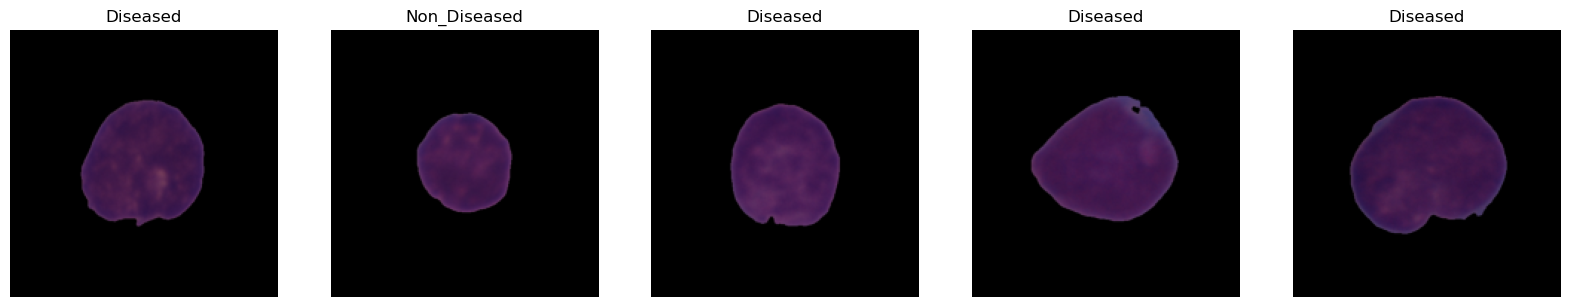

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in range(0, 5):
    rand = np.random.randint(len(images))
    ax[i].imshow(images[rand])
    ax[i].axis('off')
    a = labels[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [6]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [7]:
val_images = []

for image_name in valid_data.new_names:
    img = imread('/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    img = resize(img, (180,180))
    val_images.append(img)

val_images = np.array(val_images)

val_labels = valid_data.labels.values

In [8]:
len(val_images), len(val_labels)

(1867, 1867)

In [ ]:
# augmentation
# train_datagen  = ImageDataGenerator(horizontal_flip=True,
#                                     vertical_flip=True,
#                                     zoom_range = 0.2,
#                                     preprocessing_function=preprocess_input)
# train_datagen.fit(images)

In [9]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Model

In [10]:
pretrained_model=VGG16(input_shape = (180, 180, 3), 
                        include_top = False, 
                        weights ='imagenet')


for layer in pretrained_model.layers:
     layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
last_layer = pretrained_model.get_layer('block5_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer='adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [12]:
history = model_vgg.fit(images,
                          labels, 
                          validation_data = (val_images, val_labels),
                          epochs = 15,
                          verbose = 1)

Epoch 1/15
111/111 [==============================] - 22s 116ms/step - loss: 0.7177 - accuracy: 0.7669 - val_loss: 0.6891 - val_accuracy: 0.6695
Epoch 2/15
111/111 [==============================] - 11s 100ms/step - loss: 0.4311 - accuracy: 0.8208 - val_loss: 0.8433 - val_accuracy: 0.6754
Epoch 3/15
111/111 [==============================] - 11s 99ms/step - loss: 0.4236 - accuracy: 0.8262 - val_loss: 0.6998 - val_accuracy: 0.6770
Epoch 4/15
111/111 [==============================] - 11s 100ms/step - loss: 0.4201 - accuracy: 0.8245 - val_loss: 0.7074 - val_accuracy: 0.6877
Epoch 5/15
111/111 [==============================] - 11s 100ms/step - loss: 0.4037 - accuracy: 0.8310 - val_loss: 0.8026 - val_accuracy: 0.6834
Epoch 6/15
111/111 [==============================] - 11s 100ms/step - loss: 0.4015 - accuracy: 0.8319 - val_loss: 0.6445 - val_accuracy: 0.6856
Epoch 7/15
111/111 [==============================] - 11s 100ms/step - loss: 0.4040 - accuracy: 0.8302 - val_loss: 0.7432 - val_acc

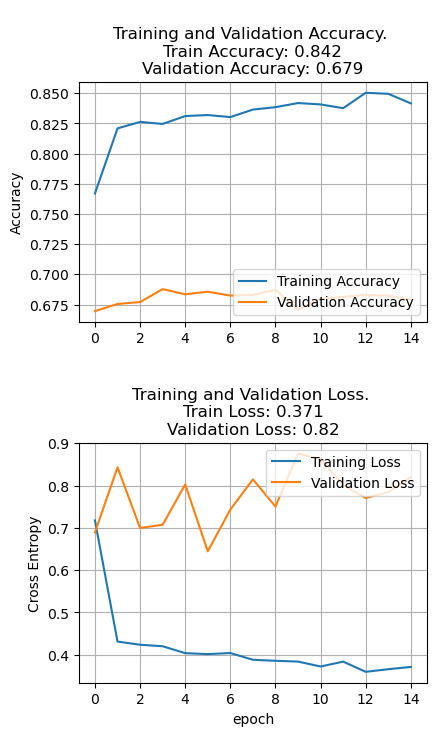

In [13]:
plot_history(history)